#**Description de projet**<br>
Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

##**P7_Modelisation.ipynb**
Cette notebook sert à la modelisation des données prétraités.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import calibration_curve
import pickle

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_row', 500)

#I. Data preparation

##I.i import data

In [2]:
# import data prepared in kaggle
path = 'drive/MyDrive/TechnicalLearning/Python/Jupyter/OC_DS_Projets/P7'
test = pd.read_csv(os.path.join(path, 'm_test_small.csv'))
train = pd.read_csv(os.path.join(path, 'm_train_small.csv'))
test.shape, train.shape

((48744, 343), (307511, 344))

In [3]:
# set ID to index
train.set_index('SK_ID_CURR', inplace=True)
test.set_index('SK_ID_CURR', inplace=True)
# remove loan status from training dataset
labels = train['TARGET']
train.drop(columns='TARGET', inplace=True)

##I.ii Split and Undersampling
1. Train test split <br>
2. Undersampling the major class data to prevent influence from imbalanced classes

In [4]:
from sklearn.model_selection import train_test_split

def splitdata(X, y, test_size=0.2):
    '''This function split data into fitting dataset and evaluation dataset'''
    (X_fit, X_eval, y_fit, y_eval) = train_test_split(
            X,
            y,
            train_size=0.8,
            test_size=test_size,
            random_state=42,
            stratify=y,
        )
    return X_fit, X_eval, y_fit, y_eval

In [5]:
from sklearn.utils import shuffle

def undersample(X, y, random_state=42):
    """This function undersample the majority class to form a balanced data"""
    # get the counts of TARGET Negative and Positive
    count_N, count_P = y.value_counts()
    # seperate 2 class
    Neg = X[y==0]
    Pos = X[y==1]
    # undersampling Major target training data to match minor data count
    if count_N > count_P:
        Neg_under = Neg.sample(count_P, random_state=random_state)
        # concat the minor data and undersampled major data
        X_balance = pd.concat([Pos, Neg_under], axis=0)
        y_balance = y.loc[X_balance.index]
    else:
        Pos_under = Pos.sample(count_N, random_state=random_state)
        X_balance = pd.concat([Neg, Pos_under], axis=0)
        y_balance = y.loc[X_balance.index]
    # shuffle the balanced data
    X_balance, y_balance = shuffle(X_balance, y_balance, random_state=42)
    return X_balance, y_balance


In [6]:
# split train data to fit models and to evaluate models
X_fit, X_eval, y_fit, y_eval = splitdata(train, labels)

# use undersampling as initial method to deal with imbalanced classification
X_balance, y_balance = undersample(X_fit, y_fit)

X_eval will preserve the property of real data by keeping original imbalanced classification structure. This helps evaluate model realistic performance.<BR>
X_fit will be undersampled to form a balanced class distribution in order to improve recall in prediction of real data.

#II. Modeling
we will use XGBoost, SVM and Logistic Regression as models

##II.i XGBoost

### 1.Modeling(undersampled data)
fit models on undersampled balanced-class data

####AUC
optimize hyperparameters of XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(n_jobs=-1, random_state=42, tree_method='gpu_hist')
params = {'objective':['binary:logistic'],
          'learning_rate': [0.05, 0.1],
          'max_depth': [3, 4, 5],
          'n_estimators': [100, 200]}


clf_XGB_auc = GridSearchCV(xgb_model, params, n_jobs=-1, cv=5, refit=True,
                       scoring='roc_auc', return_train_score=True)

clf_XGB_auc.fit(X_balance, y_balance)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, 5],
                         'n_estimator

In [ ]:
print('Mean test AUC score:\n', clf_XGB_auc.cv_results_['mean_test_score'])
print('Mean train AUC score:\n',clf_XGB_auc.cv_results_['mean_train_score'])
print('Best parameters:\n', clf_XGB_auc.best_params_)

Mean test AUC score:
 [0.75613575 0.7670642  0.76147849 0.77075649 0.76465946 0.77214162
 0.76645617 0.77292999 0.76989939 0.77381361 0.77016292 0.77220149]
Mean train AUC score:
 [0.7736873  0.79366319 0.79406183 0.82070991 0.82102938 0.85615025
 0.79341253 0.81551109 0.82004383 0.85236476 0.85532462 0.89723904]
Best parameters:
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'binary:logistic'}


####Log-loss
optimize hyperparameters of XGBoost by another scoring method(logloss)

In [ ]:
xgb_model = xgb.XGBClassifier(n_jobs=-1, random_state=42, tree_method='gpu_hist')
params = {'objective':['binary:logistic'],
          'learning_rate': [0.05, 0.1],
          'max_depth': [3, 4, 5],
          'n_estimators': [100, 200]}


clf_XGB_logloss = GridSearchCV(xgb_model, params, n_jobs=-1, cv=5, refit=True,
                       scoring='neg_log_loss', return_train_score=True)

clf_XGB_logloss.fit(X_balance, y_balance)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, 5],
                         'n_estimator

In [ ]:
print('Mean test logloss score:\n', clf_XGB_logloss.cv_results_['mean_test_score'])
print('Mean train logloss score:\n',clf_XGB_logloss.cv_results_['mean_train_score'])
print('Best parameters:\n', clf_XGB_logloss.best_params_)

Mean test logloss score:
 [-0.59287104 -0.57976074 -0.58618269 -0.57488552 -0.58196861 -0.57293129
 -0.57992372 -0.57236495 -0.57544278 -0.57089953 -0.57458252 -0.57266972]
Mean train logloss score:
 [-0.58059479 -0.55785349 -0.5615873  -0.53112013 -0.5367559  -0.49510289
 -0.55763506 -0.53287189 -0.53122739 -0.49437971 -0.49473416 -0.44323116]
Best parameters:
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'binary:logistic'}


###2.Modeling(imbalanced original data)
fit model on original imbalanced-class data

In [ ]:
# apply directly the best params of model before to train on imbalanced data
params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'binary:logistic'}
clf_XGB_imbalance = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42,
                                    tree_method='gpu_hist')
clf_XGB_imbalance.fit(X_fit, y_fit)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

###3.Compare AUC, Logloss and imbalanced

In [16]:
from sklearn.calibration import calibration_curve
def draw_calibration_curve(y_true, y_probs, legend=None, bins=50, strategy='uniform'):
    '''This function draw calibration function by given labels and probability
    predicted
    strategy: 'uniform'(all bins have same width) or 'quantile'(all bins have
    same data points). '''
    if legend == None:
        legend = range(len(probs))
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated') 
    for i in range(len(y_probs)):
        frac_of_pos, mean_pred_eval = calibration_curve(y_true, y_probs[i], n_bins=bins, strategy=strategy)
        plt.plot(mean_pred_eval, frac_of_pos, 's-', label='%s' % legend[i])
    plt.ylabel('Fraction of positives')
    plt.xlabel('Average Predicted Probability')
    plt.legend()
    plt.title('Calibration Curve')
    plt.show() 

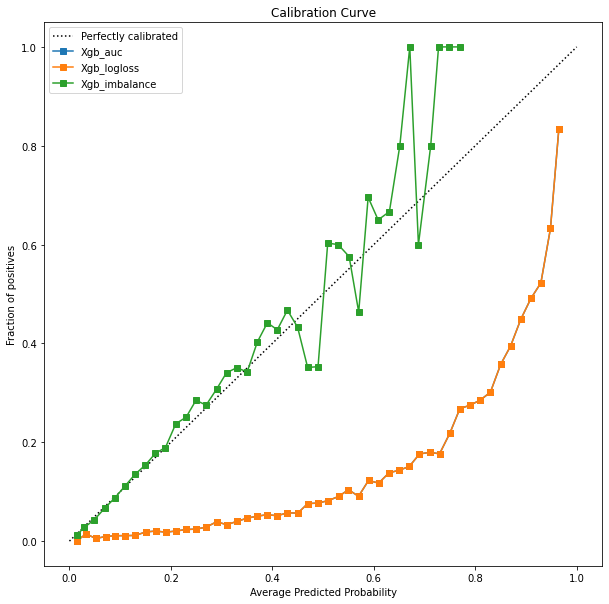

In [ ]:
# prediction(XGB models evalued by auc, logloss and fitted by imbalanced data)
auc_probs = clf_XGB_auc.best_estimator_.predict_proba(X_eval)[:,1]
logloss_probs = clf_XGB_logloss.best_estimator_.predict_proba(X_eval)[:,1]
imbalance_probs = clf_XGB_imbalance.best_estimator_.predict_proba(X_eval)[:,1]

draw_calibration_curve(y_true=y_eval, 
                       y_probs=[auc_probs, logloss_probs, imbalance_probs],
                       legend=['Xgb_auc', 'Xgb_logloss', 'Xgb_imbalance'])

In [ ]:
# using 'auc' and 'logloss' evaluation metric gives the same results
(auc_probs==logloss_probs).mean()

1.0

We notice that:<br>
1. Models evaluated by auc and logloss give exactly the same results.<br>
2. Model fitted by imbalanced data tend to give more wrong negative which would accept more defaut credit and increase the risk.<br>
3. Model fitted by undersampled balanced data, both auc and logloss, tend to give more wrong positive preditions which would refuse more non-default credit applications and decrease the turnover.<br>

Since logloss and auc give the same results, we'll use logloss as evaluation criteria hereafter.

In [11]:
from sklearn.metrics import roc_curve
def draw_roc_curve(y_true, y_probs, legend=None):
    if legend == None:
        legend = range(len(probs))
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Prediction')
    for i in range(len(y_probs)):
        fallout, recall, _ = roc_curve(y_true, y_probs[i])
        plt.plot(fallout, recall, label=legend[i])
    
    plt.legend()
    plt.title('ROC')
    plt.show()

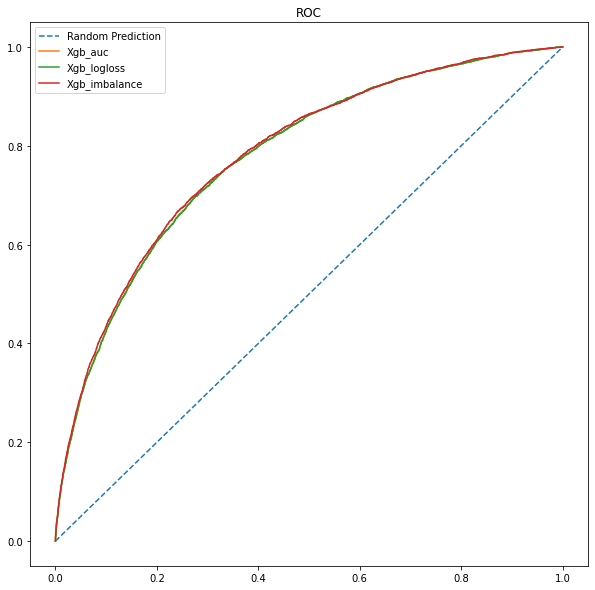

In [ ]:
draw_roc_curve(y_true=y_eval, y_probs=[auc_probs, logloss_probs, imbalance_probs],
               legend=['Xgb_auc', 'Xgb_logloss', 'Xgb_imbalance'])

The difference in ROC is not evident.

##II.ii SVM

###Accelerating tools
intall tools that accelerate the process of SVM modeling

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb


--2021-06-07 16:02:12--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2021-06-07 16:02:12--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?oNbSpHlLCe8QgctPZ5ksiT5jH3UYu0-e_Y63H8kCznVhf0oTRvdU9IRJEeyMry-6Kam_ZTU1SUy4xG-caBDsFuvG__p2C1ouD

In [ ]:
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded

cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb    drive
cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb.1  sample_data


In [ ]:
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

(Reading database ... 170084 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb ...
Unpacking cuda-repo-ubuntu1704-9-0-local (9.0.176-1) over (9.0.176-1) ...
Setting up cuda-repo-ubuntu1704-9-0-local (9.0.176-1) ...


In [ ]:
!ls /var/cuda-repo-9-0-local | grep .pub

7fa2af80.pub


In [ ]:
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub

OK


In [ ]:
!apt-get update

Get:1 file:/var/cuda-repo-9-0-local  InRelease
Ign:1 file:/var/cuda-repo-9-0-local  InRelease
Get:2 file:/var/cuda-repo-9-0-local  Release [574 B]
Get:2 file:/var/cuda-repo-9-0-local  Release [574 B]
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:

In [ ]:
!sudo apt-get install cuda-9.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'cuda-9-0' for regex 'cuda-9.0'
Note, selecting 'libcuda-9.0-1' for regex 'cuda-9.0'
cuda-9-0 is already the newest version (9.0.176-1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [ ]:
!pip install thundersvm

###Modeling(undersampled data)
use undersampled balanced-class data to fit SVM model

In [ ]:
from thundersvm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
params= {'C':np.logspace(-1,1,3),
        } 

grid_svc = GridSearchCV(SVC(probability=True, random_state=42), params,
                       n_jobs=-1, cv=5, refit=True, scoring='neg_log_loss',
                        return_train_score=True)

svc_model = Pipeline([('Imputer', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()),
                 ('svc', grid_svc)])

svc_model.fit(X_balance, y_balance)

Pipeline(memory=None,
         steps=[('Imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 GridSearchCV(cv=5, error_score=nan,
                              estimator=SVC(C=1.0, cache_size=None,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovo',
                                            degree=3, gamma='auto', gpu_id=0,
                                            kernel='rbf', max_iter=-1,
                                            max_mem_size=-1, n_jobs=-1,
                                            probability=True, random_state=42,
                                            shrinking=False

In [ ]:
print('Mean test svc score:\n', svc_model['svc'].cv_results_['mean_test_score'])
print('Mean train svc score:\n', svc_model['svc'].cv_results_['mean_train_score'])
print('Best parameters:\n', svc_model['svc'].best_params_)

Mean test svc score:
 [-0.5888089  -0.58481849 -0.61921551]
Mean train svc score:
 [-0.56685763 -0.46592339 -0.33261102]
Best parameters:
 {'C': 1.0}


In [ ]:
svc_probs = svc_model.predict_proba(X_eval)[:, 1]

##II.iii Logistic Regression

###Modeling(undersampled data)
use undersampled balanced-class data to fit logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

params = {"C":np.logspace(-3,0,4)}

grid_lr = GridSearchCV(LogisticRegression(), params, n_jobs=-1, cv=5,
                       refit=True, scoring='neg_log_loss',
                       return_train_score=True)

lr_model = Pipeline([('Imputer', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()),
                 ('lr', grid_lr)])

lr_model.fit(X_balance, y_balance)

Pipeline(memory=None,
         steps=[('Imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 GridSearchCV(cv=5, error_score=nan,
                              estimator=LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                        

In [ ]:
print('Mean test lr score:\n', lr_model['lr'].cv_results_['mean_test_score'])
print('Mean train lr score:\n',lr_model['lr'].cv_results_['mean_train_score'])
print('Best parameters:\n', lr_model['lr'].best_params_)

Mean test lr score:
 [-0.58122319 -0.58181653 -0.58298685 -0.58325436]
Mean train lr score:
 [-0.57452043 -0.57109354 -0.57052502 -0.57049732]
Best parameters:
 {'C': 0.001}


In [ ]:
lr_probs = lr_model.predict_proba(X_eval)[:, 1]

##III.iv Comparison
1. Here before, by comparing the mean logloss of cross validation of XGBoost, SVM and LR, the **XGBoost** gives the best result.<br>
2. Here below, we compare 3 models: XGBoost, SVM, Logistic Regression by calibration curve.<br>
All models are fitted on undersampled balanced data

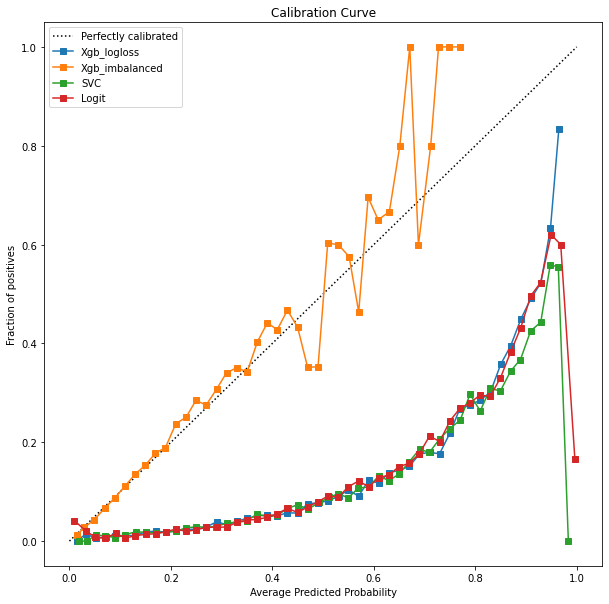

In [ ]:
draw_calibration_curve(y_true=y_eval, 
                       y_probs=[logloss_probs, imbalance_probs, svc_probs, lr_probs],
                       legend=['Xgb_logloss', 'Xgb_imbalanced', 'SVC', 'Logit'])

We notice that XGBoost gives the best result comparing to SVM and Logistic Regression. Here after, we will use only XGBoost for improvement in imbalanced classification.

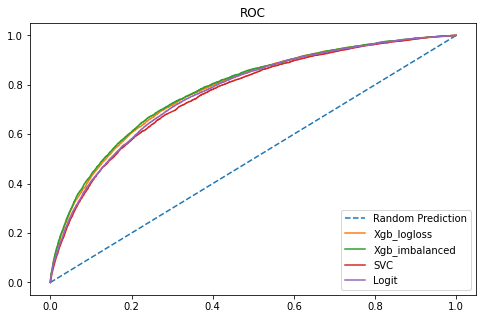

In [ ]:
# the roc curves are too close to distinguish the models' performance.
draw_roc_curve(y_true=y_eval, 
               y_probs=[logloss_probs, imbalance_probs, svc_probs, lr_probs],
               legend=['Xgb_logloss', 'Xgb_imbalanced', 'SVC', 'Logit'])

# III. Imbalanced classification
Before we use the undersampling method to improve imbalanced classification. Now we'll use other methods to improve imbalanced classifcation, only with the best model: XGBoost.<br>

Methods to improve imbalanced classification:<br>
**undersampling**: undersample the majority class<br>
**scale_pos_weight**: hyperparameter in XGBoost model, scale_pos_weight is used to scale the gradient for the positive class<br>
**SMOTE**: Oversampling the minority class<br>
**SMOTE_combine**: combine the oversampling of minority class and undersampling of majority class. This method is recommended by author of SMOTE.<br>


##III.i undersampling

In [ ]:
# model fitted on undersampling balanced data
params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'binary:logistic'}
clf_XGB_undersample = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42,
                                    tree_method='gpu_hist')
clf_XGB_undersample.fit(X_balance, y_balance)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

##III.ii Hyperparam: scale_pos_weight

In [ ]:
# model fitted on imbalanced original data, but configured with scale_pos_weight
# we've test ratio, ratio/2, ratio/3, ratio/4 then find that ratio/3 is the best
params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'binary:logistic'}
ratio = labels.value_counts()[0]/labels.value_counts()[1]
clf_XGB_scalepos = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42,
                                    tree_method='gpu_hist', scale_pos_weight=ratio/3)
clf_XGB_scalepos.fit(X_fit, y_fit)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.7957166834508222,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)

##III.iii SMOTE

In [ ]:
# model fitted with SMOTE oversampling data
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_new = imputer.fit_transform(X_fit, y_fit)
oversample = SMOTE(random_state=42)       
X_SMOTE, y_SMOTE = oversample.fit_resample(X_new, y_fit)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
clf_XGB_SMOTE = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42,
                                    tree_method='gpu_hist')
clf_XGB_SMOTE.fit(X_SMOTE, y_SMOTE)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

##III.iv SMOTE_combine
combine SMOTE oversampling of minority with undersampling of majority

In [ ]:
# 用smote + undersampling 的方法
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(random_state=42, sampling_strategy=0.1)
under = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_SMOTE_combine, y_SMOTE_combine = pipeline.fit_resample(X_new, y_fit)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
clf_XGB_SMOTE_combine = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42,
                                    tree_method='gpu_hist')
clf_XGB_SMOTE_combine.fit(X_SMOTE_combine, y_SMOTE_combine)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [ ]:
# orginal data class ratio, undersampling class condition, oversampling c
from collections import Counter
print('original class counts:\n {}'.format(Counter(y_fit)))
print('undersampling class counts:\n {}'.format(Counter(y_balance)))
print('Oversampling class counts:\n {}'.format(Counter(y_SMOTE)))
print('Combined undersampling & oversampling class counts:\n {}'.format(
    Counter(y_SMOTE_combine)))

original class counts:
 Counter({0: 226148, 1: 19860})
undersampling class counts:
 Counter({0: 19860, 1: 19860})
Oversampling class counts:
 Counter({0: 226148, 1: 226148})
Combined undersampling & oversampling class counts:
 Counter({0: 45228, 1: 22614})


##III.v XGBoost with impute data
after comparing beyond methods, we found scale_pos_weight is the best. Then we add a xgboost_scale_pos fitted by imputed data, since we want to apply the library 'lime', which doesn't accept missing data.

In [13]:
imputer =SimpleImputer(strategy='median')
X_fit_imputed = imputer.fit_transform(X_fit)

In [ ]:
X_fit_imputed = pd.DataFrame(X_fit_imputed, index=X_fit.index, columns=X_fit.columns)

In [ ]:
params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'binary:logistic'}
ratio = labels.value_counts()[0]/labels.value_counts()[1]
clf_XGB_scalepos_imputed = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42,
                                    tree_method='hist', scale_pos_weight=ratio/3)
clf_XGB_scalepos_imputed.fit(X_fit_imputed, y_fit)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.7957166834508222,
              seed=None, silent=None, subsample=1, tree_method='hist',
              verbosity=1)

##III.vi Comparison
Compare different methods to improve imbalanced classification

#### 1.cost function definition

In [10]:
# calculated net estimated value of each model
def strategy_dataframe(y_probs, y_trues=y_eval, profit_rate=0.2, lgd=1):
    '''This function return strategy dataframe of given predicted probability
    
    Parameters
    --------
        y_trues(dataframe): true loan status

        y_probs(dataframe): positive probability predictions

        profit_rate(float): the earning rate of credit. For example: 0.1 means
        that earning of this loan = 10% * total_loan_amnt

        lgd(float): Loss given default (LGD) is the amount of money we lose 
        when a borrower defaults on a loan, after taking into consideration any 
        recovery, represented as a percentage of total exposure at the time of 
        loss. Here we suppose total exposure = total loan_amnt
        
    Return
    --------
        df_strat(dataframe):
        a dataframe including different estimated values (profit - loss) when
        adopting different acceptance rates(from 0 to 1). acceptance rate = 0
        means we accept no credit, no loss and no profit. acceptance rate = 1
        means we accept all credit, the profit is maximum but the loss from
        default loans is also maximum'''
        
    
    df = pd.DataFrame(y_probs, columns=['probs'], index=X_eval.index)
    df['AMT_CREDIT'] = X_eval['AMT_CREDIT'].values
    df['true_loan_status'] = y_trues.values

    # rate of credit applications we decide to accept
    accept_rates = np.linspace(0.05, 1, 20)
    # threshold of defaut probability to accept
    thresholds = []
    # percentage of accedpted loans that are defaults
    bad_rates = []
    # profit - loss for each acceptance rate
    estimated_value = []

    for rate_ in accept_rates:

        # calculate threshold according to acceptance rate
        thresh = np.quantile(df['probs'], rate_).round(3)
        thresholds.append(thresh)

        # apply threshold to predict loan_status
        df['pred_loan_status'] = df['probs']\
        .apply(lambda x: 1 if x > thresh else 0)
        accepted_loans = df[df['pred_loan_status']==0]

        # percentage of bad credit in accepted credit
        bad_rates.append(np.sum(
            (accepted_loans['true_loan_status']) \
            / len(accepted_loans['true_loan_status'])).round(3))
        
        # profit = total capital of accepted non default loans * profit_rate
        profit = accepted_loans[accepted_loans['true_loan_status']==0]\
        ['AMT_CREDIT'].sum() * profit_rate

        # loss = total capital of accepted default loans * loss_given_rate
        loss = accepted_loans[accepted_loans['true_loan_status']==1]\
        ['AMT_CREDIT'].sum() * lgd
        # real earning
        estimated_value.append(profit - loss)

    df_strat = pd.DataFrame(zip(accept_rates, thresholds, bad_rates,
                                estimated_value),
                         columns=['acceptance_rate', 'threshold', 'bad_rate',
                                  'estimated_value'])
    # number of accepted loans
    df_strat['n_accepted_loans'] = df_strat['threshold'].apply(
        lambda x: len(df[df['probs']<x]))

    return df_strat

#### 2.compare models

In [9]:
# import models
from os.path import join
model_lr = pickle.load(open(join('model_lr.pkl'), 'rb'))
clf_XGB_imbalance = pickle.load(open(join('model_xgb_imbalance.pkl'), 'rb'))
clf_XGB_undersample = pickle.load(open(join('model_xgb_undersample.pkl'), 'rb'))
clf_XGB_scalepos = pickle.load(open(join('model_xgb_scalepos.pkl'), 'rb'))
clf_XGB_SMOTE = pickle.load(open(join('model_xgb_SMOTE.pkl'), 'rb'))
clf_XGB_SMOTE_combine = pickle.load(open(join('model_xgb_SMOTE_combine.pkl'), 'rb'))
clf_XGB_scalepos_imputed = pickle.load(open(join('model_xgb_scalepos_imputed.pkl'), 'rb'))

In [14]:
# prediction of models
prob_models = []
for m in [model_lr, clf_XGB_imbalance, clf_XGB_undersample, clf_XGB_scalepos]:
    tmp = m.predict_proba(X_eval)[:,1]
    prob_models.append(tmp)

for m in [clf_XGB_SMOTE, clf_XGB_SMOTE_combine]:
    tmp = m.predict_proba(X_eval.to_numpy())[:,1]
    prob_models.append(tmp)

  
X_eval_imputed = imputer.transform(X_eval)
X_eval_imputed = pd.DataFrame(X_eval_imputed, index=X_eval.index, columns=X_eval.columns)
tmp =clf_XGB_scalepos_imputed.predict_proba(X_eval_imputed)[:,1]
prob_models.append(tmp)

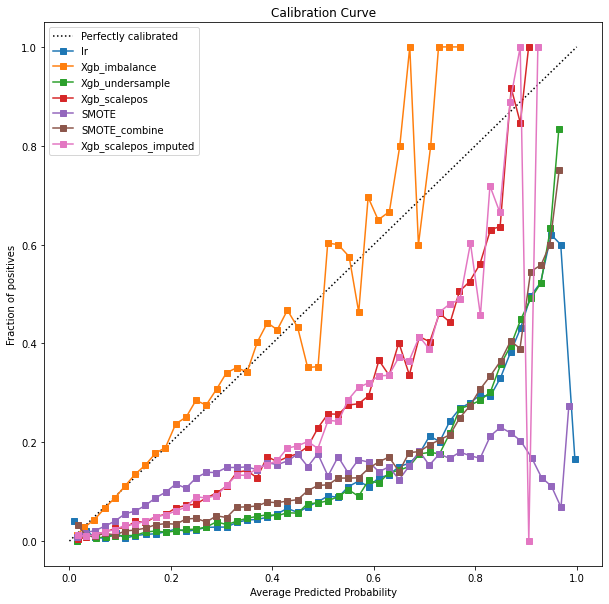

In [17]:
draw_calibration_curve(y_true=y_eval, 
                       y_probs=prob_models,
                       legend=['lr', 'Xgb_imbalance', 'Xgb_undersample', 'Xgb_scalepos', 'SMOTE', 'SMOTE_combine', 'Xgb_scalepos_imputed'])

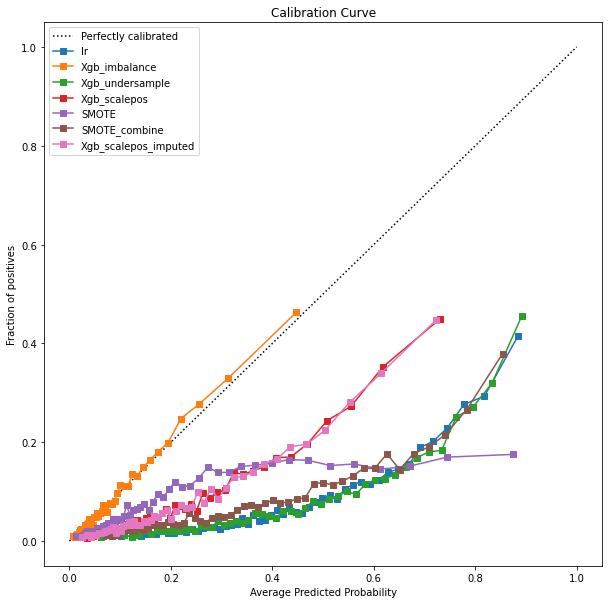

In [18]:
# strategy 'quantile' means each bin have the same number of observations.
draw_calibration_curve(y_true=y_eval, 
                       y_probs=prob_models, strategy='quantile',
                       legend=['lr', 'Xgb_imbalance', 'Xgb_undersample', 'Xgb_scalepos', 'SMOTE', 'SMOTE_combine', 'Xgb_scalepos_imputed'])

According to calibration curve, we noticed that:<br>
1. In term of improvement of imbalanced classification, Xgboost imporved by hyperparameter 'scale_pos_weight' gives the best result.
2. In term of imputation, xgboost fitted by imputated data and xgboost fitted by sparse data give similar result.

In [19]:
lr_model_strat = strategy_dataframe(prob_models[0])
xgb_imbalance_strat = strategy_dataframe(prob_models[1])
xgb_undersample_strat = strategy_dataframe(prob_models[2])
xgb_scalepos_strat = strategy_dataframe(prob_models[3])
xgb_SMOTE_strat = strategy_dataframe(prob_models[4])
xgb_SMOTE_combine_strat = strategy_dataframe(prob_models[5])
xgb_scalepos_imputed_strat = strategy_dataframe(prob_models[6])
print('lr model: ${:,.2f}'.format(lr_model_strat['estimated_value'].max()))
print('imbalanced xgb: ${:,.2f}'.format(xgb_imbalance_strat['estimated_value'].max()))
print('undersample xgb: ${:,.2f}'.format(xgb_undersample_strat['estimated_value'].max()))
print('scalepos xgb: ${:,.2f}'.format(xgb_scalepos_strat['estimated_value'].max()))
print('SMOTE xgb: ${:,.2f}'.format(xgb_SMOTE_strat['estimated_value'].max()))
print('SMOTE combine xgb: ${:,.2f}'.format(xgb_SMOTE_combine_strat['estimated_value'].max()))
print('scalepos imputed xgb: ${:,.2f}'.format(xgb_scalepos_imputed_strat['estimated_value'].max()))

lr model: $4,456,926,394.20
imbalanced xgb: $4,527,382,111.20
undersample xgb: $4,500,780,624.00
scalepos xgb: $4,542,448,975.20
SMOTE xgb: $4,023,113,270.40
SMOTE combine xgb: $4,299,103,280.70
scalepos imputed xgb: $4,509,661,919.40


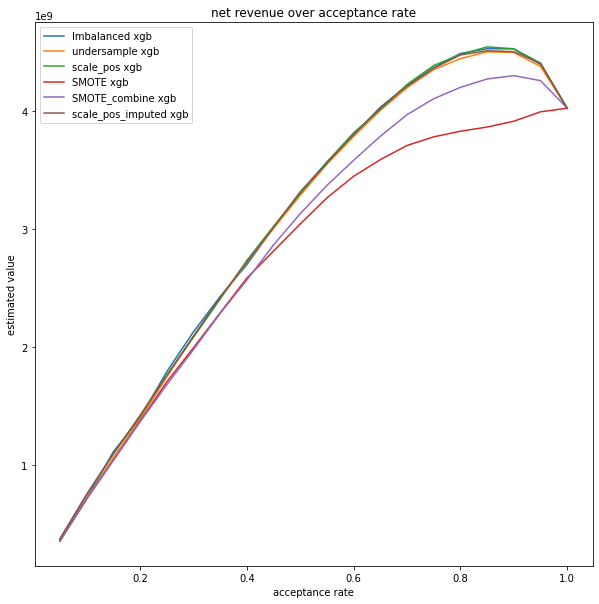

In [21]:
# detect the best threshold for scoring
accept_rates = xgb_imbalance_strat['acceptance_rate']
plt.figure(figsize=(10,10))
plt.plot(accept_rates, xgb_imbalance_strat['estimated_value'], label='Imbalanced xgb')
plt.plot(accept_rates, xgb_undersample_strat['estimated_value'], label='undersample xgb')
plt.plot(accept_rates, xgb_scalepos_strat['estimated_value'], label='scale_pos xgb')
plt.plot(accept_rates, xgb_SMOTE_strat['estimated_value'], label='SMOTE xgb')
plt.plot(accept_rates, xgb_SMOTE_combine_strat['estimated_value'], label='SMOTE_combine xgb')
plt.plot(accept_rates, xgb_scalepos_imputed_strat['estimated_value'], label='scale_pos_imputed xgb')
plt.xlabel('acceptance rate')
plt.ylabel('estimated value')
plt.title('net revenue over acceptance rate')
plt.legend()
plt.show()

In [22]:
# best acceptance rate and threshold for XGBoost_scale_pos model
xgb_scalepos_imputed_strat.sort_values('estimated_value', ascending=False).head(5)

,acceptance_rate,threshold,bad_rate,estimated_value,n_accepted_loans
16,0.85,0.384,0.050,4.509662e+09,52294
17,0.90,0.450,0.057,4.502041e+09,55350
15,0.80,0.333,0.044,4.474492e+09,49223
18,0.95,0.551,0.065,4.403324e+09,58415
14,0.75,0.293,0.040,4.361820e+09,46127


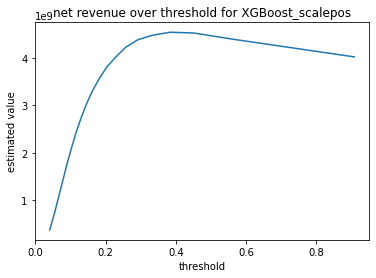

In [27]:
plt.plot(xgb_scalepos_strat['threshold'], xgb_scalepos_strat['estimated_value'])
plt.xlabel('threshold')
plt.ylabel('estimated value')
plt.title('net revenue over threshold for XGBoost_scalepos')
plt.show()

Conclusion:<br>
The best acceptance rate is at 85%.<br>
The best threshold of acceptance of loans is 0.384, which means all loans scored over 0.384 should be rejected. 

In [ ]:
# thundersvm doesn't support format .pkl
# sklearn svm takes several times longer compared to the others
# svm result is not standout according to calibration curve
# so we decide not to export svm model
pickle.dump(lr_model, open(os.path.join(path, 'model_lr.pkl'), 'wb'))
pickle.dump(clf_XGB_scalepos, open(os.path.join(path, 'model_xgb_scalepos.pkl'), 'wb'))
pickle.dump(clf_XGB_undersample, open(os.path.join(path, 'model_xgb_undersample.pkl'), 'wb'))
pickle.dump(clf_XGB_imbalance, open(os.path.join(path, 'model_xgb_imbalance.pkl'), 'wb'))
pickle.dump(clf_XGB_SMOTE, open(os.path.join(path, 'model_xgb_SMOTE.pkl'), 'wb'))
pickle.dump(clf_XGB_SMOTE_combine, open(os.path.join(path, 'model_xgb_SMOTE_combine.pkl'), 'wb'))
pickle.dump(clf_XGB_scalepos_imputed, open(os.path.join(path, 'model_xgb_scalepos_imputed.pkl'), 'wb'))

# IV. Export

## export models
For local running, I have to reset 'tree method' by defaut. 'gpu-hist' is only for colab.
What's more, we need to refit the model on all training data

In [16]:
params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'binary:logistic'}

In [116]:
# refit model on all training data imputed (numpy format)
imputer =SimpleImputer(strategy='median')
train_imputed = imputer.fit_transform(train)

ratio = labels.value_counts()[0]/labels.value_counts()[1]
clf_XGB_final_imputed_np = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42,
                                    tree_method='hist', scale_pos_weight=ratio/3)
clf_XGB_final_imputed_np.fit(train_imputed, labels.values)
pickle.dump(clf_XGB_final_imputed_np, open(os.path.join(path, 'model_xgb_final_imputed_np.pkl'), 'wb'))

In [10]:
clf_XGB_final_imputed_np = pickle.load(open(join('model_xgb_final_imputed_np.pkl'), 'rb'))

In [40]:
# export a sample a training data for api
train_sample = train.sample(n=30000, random_state=42)
# imputation based on all train data
imputer =SimpleImputer(strategy='median')
imputer.fit(train)
pickle.dump(imputer, open('imputer.pkl', 'wb'))
# export train sample
train_imputed_sample = imputer.transform(train_sample)
# export corresponding labels
labels_sample = labels.sample(n=30000, random_state=42)
# export test sample
test_sample =test.sample(n=1000, random_state=42)

In [41]:
# export in one pickle (should be <100Mo to be saved in github)
data = {}
data['imputer'] = imputer
data['model'] = clf_XGB_final_imputed_np
#data['train_imputed'] = train_imputed_sample
data['train'] = train_sample
data['labels'] = labels_sample
data['test'] = test_sample

In [45]:
pickle.dump(data, open(os.path.join(path, 'data.pkl'), 'wb'))
os.stat('data.pkl').st_size/(1024 * 1024)

82.09945964813232

##Export for heroku
Exclusive for run on heroku web<br>
as heroku don't accept heavy duty(which would cause 'h12' request timeout error), we have to drop some features to make our algorithm light enough to run on heroku free server.

In [5]:
data = pickle.load((open(os.path.join(path, 'data.pkl'), 'rb')))
model = data['model']

In [14]:
# we keep only top 50 features
idx = model.feature_importances_.argsort()[-50:][::-1]
top50_feature = train.columns[idx].tolist()
top50_feature

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_INCOME_TYPE_Working',
 'client_credit_AMT_BALANCE_min_sum',
 'FLAG_DOCUMENT_3',
 'CODE_GENDER_F',
 'client_credit_AMT_DRAWINGS_CURRENT_mean_max',
 'client_installments_AMT_PAYMENT_min_sum',
 'previous_NAME_PRODUCT_TYPE_walk-in_mean',
 'client_installments_AMT_PAYMENT_min_max',
 'bureau_DAYS_CREDIT_mean',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'previous_NAME_CONTRACT_STATUS_Refused_mean',
 'EXT_SOURCE_1',
 'previous_CNT_PAYMENT_max',
 'bureau_CREDIT_ACTIVE_Active_count_norm',
 'DAYS_BIRTH',
 'previous_AMT_DOWN_PAYMENT_max',
 'client_cash_SK_DPD_max_min',
 'previous_NAME_CONTRACT_STATUS_Approved_mean',
 'client_cash_SK_DPD_DEF_mean_min',
 'previous_CODE_REJECT_REASON_SCOFR_mean',
 'DAYS_EMPLOYED',
 'previous_CNT_PAYMENT_mean',
 'FLOORSMAX_AVG',
 'client_cash_CNT_INSTALMENT_FUTURE_mean_mean',
 'client_credit_AMT_RECIVABLE_mean_max',
 'previous_NAME_YIELD_GROUP_high_mean',
 'OWN_CAR_AGE',
 'cl

In [18]:
params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'objective': 'binary:logistic'}

# set up new data for heroku deployment
train = train[top50_feature]
imputer =SimpleImputer(strategy='median')
train_imputed = imputer.fit_transform(train)

ratio = labels.value_counts()[0]/labels.value_counts()[1]
clf_XGB_final_imputed_np = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42,
                                    tree_method='hist', scale_pos_weight=ratio/3)
clf_XGB_final_imputed_np.fit(train_imputed, labels.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.7957166834508222,
              seed=None, silent=None, subsample=1, tree_method='hist',
              verbosity=1)

In [22]:
# export a sample a training data for api
train_sample = train.sample(n=30000, random_state=42)
# export train sample
train_imputed_sample = imputer.transform(train_sample)
# export corresponding labels
labels_sample = labels.sample(n=30000, random_state=42)
# export test sample
test_sample =test[top50_feature].sample(n=1000, random_state=42)

In [36]:
data_heroku = {}
data_heroku = {}
data_heroku['imputer'] = imputer
data_heroku['model'] = clf_XGB_final_imputed_np
#data['train_imputed'] = train_imputed_sample
data_heroku['train'] = train_sample
data_heroku['labels'] = labels_sample
data_heroku['test'] = test_sample
description_col = pd.read_csv('HomeCredit_columns_description.csv', encoding='unicode_escape')
data_heroku['description'] = description_col
pickle.dump(data_heroku, open(os.path.join(path, 'data_heroku.pkl'), 'wb'))

In [ ]:
os.stat('data_heroku.pkl').st_size/(1024 * 1024)

#Brouillon

In [ ]:
import gc
del X_SMOTE_combine2, X_SMOTE_combine3
gc.collect()

597

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       X_SMOTE:  1.2 GiB
                         train: 804.7 MiB
                         X_fit: 643.8 MiB
               X_SMOTE_combine: 177.0 MiB
                        X_eval: 160.9 MiB
                          test: 127.6 MiB
                     X_balance: 103.9 MiB
                         y_fit: 13.8 MiB
                        labels:  4.7 MiB
                       y_SMOTE:  3.5 MiB


In [ ]:
desp

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
